# poly fit implementation with weights


In [1]:
import sys
import hvplot.xarray
sys.path.append("/Users/jkingslake/Documents/science/ApRES/xapres")
import xapres as xa
import matplotlib.pyplot as plt
import xarray as xr
from datatree import DataTree
import numpy as np

In [2]:
def load_zarr(f):
    return xr.open_dataset(f, engine = 'zarr', chunks = {})
LTG = load_zarr('zarrs/LTG_stacked.zarr').load()
LK1 = load_zarr('zarrs/LK1_stacked.zarr').load()
LK2 = load_zarr('zarrs/LK2_stacked.zarr').load()

In [3]:
dLTG = LTG.profile_stacked.displacement_timeseries().compute()
dLK1 = LK1.profile_stacked.displacement_timeseries().compute()
dLK2 = LK2.profile_stacked.displacement_timeseries().compute()

In [4]:
lower_limit_on_fit = 800
ezzLTG = dLTG.displacement.squeeze().where(dLTG.displacement.bin_depth < lower_limit_on_fit)\
                    .polyfit('bin', 1)\
                    .polyfit_coefficients.sel(degree=1)

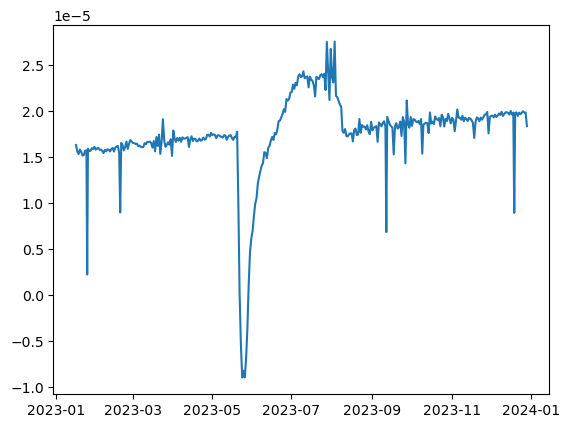

In [78]:
lower_limit_on_fit=800
ds = dLTG.transpose('bin',...)
x = ds.bin_depth.values
time = ds.time.values
y = ds.displacement.squeeze()
w = xr.where(ds.displacement.bin_depth < lower_limit_on_fit, 1, 0).squeeze().values

p = np.empty((len(time), 2))

for i, t in enumerate(time):
    p[i,0], p[i,1] = np.polynomial.polynomial.polyfit(x = x, y = y[:,i], deg = 1, w=w)
plt.plot(time, p[:,1])

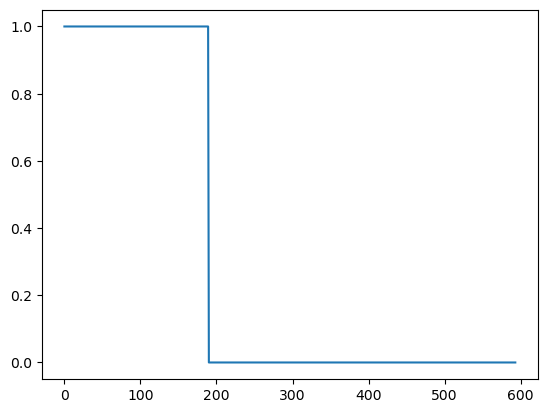

In [75]:
plt.plot(w)

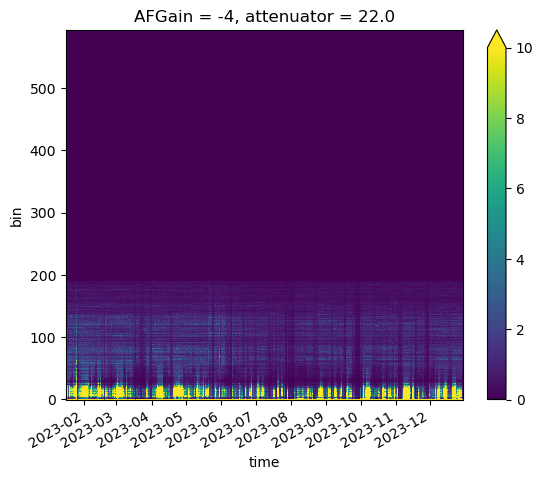

In [72]:
w_xr = xr.where(ds.displacement.bin_depth < lower_limit_on_fit, 1/ds.disp_uncertainty, 0).squeeze()
w_xr /= w_xr.mean()
w_xr.plot(vmax=10)

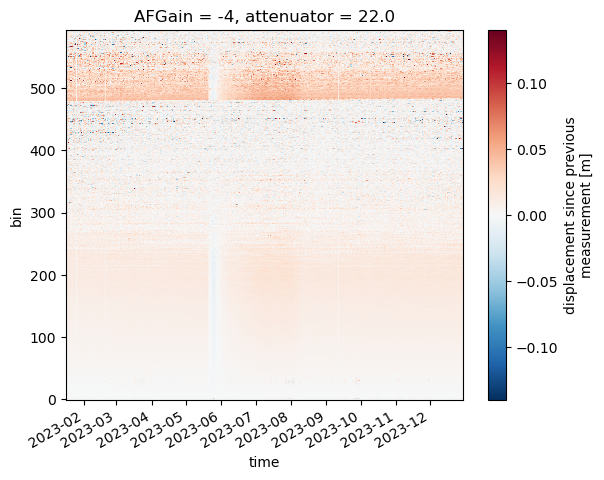

In [54]:
ds.displacement.squeeze().plot()

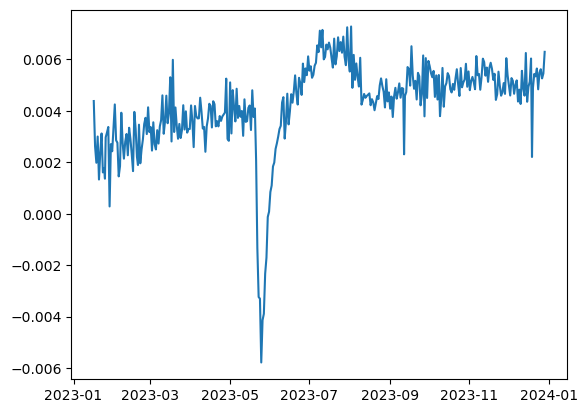

In [53]:
plt.plot(time, p[:,1])

In [59]:
np.polynomial.polynomial.polyfit(x, y, deg = 1)

TypeError: expected x and y to have same length

In [14]:
def ComputeStrainRates(ds, lower_limit_on_fit = 800):


    disp = ds.displacement.squeeze().transpose('bin',...)
    #weights = 1/ds.disp_uncertainty.squeeze().transpose('bin',...)
    x = ds.bin_depth.values
    #time = da.time.values
    y = disp.values
    weights = xr.where(dLTG.displacement.bin_depth < lower_limit_on_fit, 1/ds.disp_uncertainty, 0)
    strain_rate, surface_intercept = np.polynomial.polynomial.polyfit(x, y, deg = 1, w = weights)
    
    temp = xr.zeros_like(da.isel(bin=0)).rename('strain_rate')
    strain_rate += temp.rename('strain_rate')
    strain_rate.attrs['units'] = 'TBD'
    strain_rate.attrs['long_name'] = f"vertical strain rate in upper {lower_limit_on_fit} m."
    surface_intercept += temp.rename('intercept')
    surface_intercept.attrs['units'] = 'TBD'
    surface_intercept.attrs['long_name'] = 'vertical velocity at the surface'
    
    return xr.merge([strain_rate, surface_intercept])
xr.Dataset.ComputeStrainRates = ComputeStrainRates

In [15]:
dLTG.squeeze().ComputeStrainRates().strain_rate.plot()

TypeError: expected 1D vector for w

In [19]:
dLTG.displacement

<xarray.DataArray 'displacement' (time: 350, attenuator_setting_pair: 1,
                                  bin: 594)>
array([[[ 2.22083144e-06, -1.44074578e-02, -4.72896407e-03, ...,
         -6.53536166e-03,  6.27862706e-03, -2.70490619e-02]],

       [[-8.28043824e-07,  1.00833584e-04, -5.89352965e-04, ...,
          3.12956901e-02,  9.78401901e-03, -2.45968616e-02]],

       [[-1.03634228e-07,  6.93656897e-03,  9.17033322e-04, ...,
         -1.06335408e-02, -1.84218561e-02, -8.46599728e-03]],

       ...,

       [[-3.85996969e-07,  3.66167471e-04, -6.52141464e-05, ...,
          2.27129888e-02,  5.89303479e-03,  2.80846108e-02]],

       [[-4.17572599e-08,  5.01908402e-04, -1.45907460e-04, ...,
         -5.52899927e-03, -1.06224206e-02, -2.06668421e-02]],

       [[ 4.69530248e-06,  2.65833051e-02, -2.87311048e-04, ...,
         -4.40925695e-03,  2.18861676e-02,  3.24350201e-02]]])
Coordinates:
    AFGain       (attenuator_setting_pair) int64 -4
    attenuator   (attenuator_setting_pair) float64 22.0
    orientation  (time) <U7 'unknown' 'unknown' ... 'unknown' 'unknown'
  * time         (time) datetime64[ns] 2023-01-16T12:51:57.500000 ... 2023-12...
    bin_depth    (bin) float64 1.998 6.204 10.41 ... 2.492e+03 2.496e+03
Dimensions without coordinates: attenuator_setting_pair, bin
Attributes:
    units:      m
    long_name:  displacement since previous measurement

In [27]:
# Define the weighted linear least squares fit function
def weighted_linear_fit(data, axis, weights=None):
    
    print(data.shape)
    bins = np.arange(data.shape[axis])
    #if weights is None:
    #    weights = np.ones_like(data)
    
    # Perform weighted linear least squares fit
    coefficients = np.polynomial.polynomial.polyfit(bins, data, 1)
    #fit_line = np.polynomial.polynomial.polyfit(coefficients, bins)
    
    # Return the reduced data
    return coefficients

# Apply the function using xarray's reduce method
dLTG.displacement.reduce(weighted_linear_fit, dim='bin')


(350, 1, 594)


TypeError: expected 1D or 2D array for y

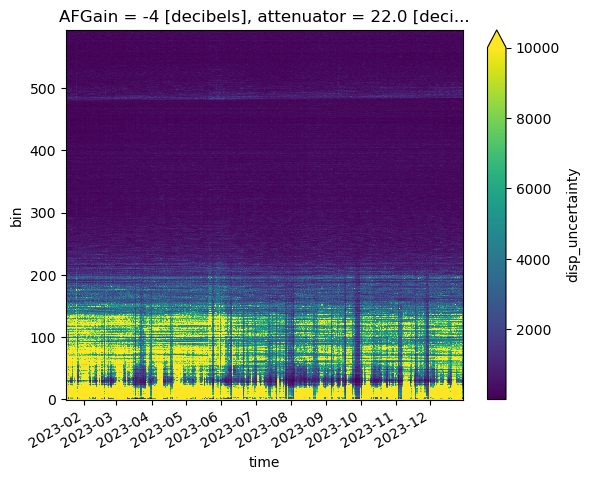

In [4]:
ds = dLTG
weights = 1/ds.disp_uncertainty.squeeze().transpose('bin',...)
weights.plot(vmax = 1e4)

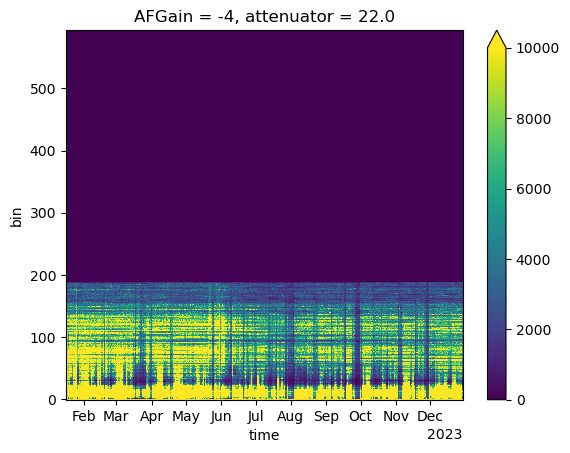

In [7]:
lower_limit_on_fit=800
#ds = dLTG.where(dLTG.displacement.bin_depth < lower_limit_on_fit)
#weights = 1/ds.disp_uncertainty.squeeze().transpose('bin',...)
weights.plot(vmax = 1e4)

In [109]:
temp = xr.zeros_like(da.isel(bin=0)).rename('strain_rate')
strain_rate += temp.rename('strain_rate')
strain_rate.attrs['units'] = 'TBD'
strain_rate.attrs['long_name'] = f"vertical strain rate in upper {lower_limit_on_fit} m."
surface_intercept += temp.rename('intercept')
surface_intercept.attrs['units'] = 'TBD'
surface_intercept.attrs['long_name'] = 'vertical velocity at the surface'
xr.merge([strain_rate, surface_intercept])

In [108]:
surface_intercept

<xarray.DataArray 'intercept' (time: 350)> Size: 3kB
array([ 2.81075837e-06,  3.80720782e-06,  6.17591630e-06,  3.75030427e-06,
        6.18379898e-06,  3.65127123e-06,  3.78556313e-06,  5.99235099e-06,
        5.15559638e-06, -1.98342671e-07,  4.56668423e-06,  3.29081477e-06,
        4.02021535e-06,  7.20037239e-06,  3.78901934e-06,  4.33810315e-06,
        3.92800103e-06,  2.44986670e-06,  4.06297606e-06,  3.90261393e-06,
        5.44152596e-06,  5.36002225e-06,  3.58317455e-06,  3.54167255e-06,
        4.80265389e-06,  4.15340842e-06,  3.14515105e-06,  5.35337847e-06,
        3.66468363e-06,  4.54125363e-06,  4.78297004e-06,  5.06048225e-06,
        2.88698948e-06,  4.76923737e-06,  5.23246450e-06,  2.06727798e-06,
        2.83363522e-06,  4.93597961e-06,  4.41158039e-06,  3.88218711e-06,
        3.36283145e-06,  2.98534871e-06,  4.01372506e-06,  2.98052984e-06,
        4.60295391e-06,  4.08798252e-06,  4.03997653e-06,  4.27559560e-06,
        3.99786255e-06,  4.91332996e-06,  3.62987429e-06,  4.71494582e-06,
        4.09442989e-06,  2.90920534e-06,  2.61201592e-06,  4.42613456e-06,
        3.19381562e-06,  1.84222852e-06,  3.47697250e-06,  3.32966289e-06,
        1.68316261e-06,  4.39343169e-06,  1.81163251e-06,  3.98212636e-06,
        3.52455070e-06,  3.24110194e-06,  3.93691505e-06,  4.03915305e-06,
        4.04179665e-06,  4.07958221e-06,  2.88964771e-06,  3.31944144e-06,
        2.73987918e-06,  3.84796540e-06,  3.59022503e-06,  3.39435268e-06,
        2.88759336e-06,  3.10661590e-06,  4.88833293e-06,  2.56568789e-06,
...
        2.24893578e-06,  2.21731712e-06,  1.96428641e-06,  1.97323797e-06,
        2.53325254e-06,  3.21712637e-06,  2.44260923e-06,  2.78075901e-06,
        2.54401282e-06,  1.74173168e-06,  2.91931278e-06,  3.02485189e-06,
        1.27967305e-06,  3.31782293e-06,  2.66144051e-06,  2.58265776e-06,
        1.77043500e-06,  2.94085930e-06,  1.91282201e-06,  3.11927752e-06,
        2.17169894e-06,  2.78740746e-06,  2.84992106e-06,  2.65335938e-06,
        1.23554273e-06,  2.09011356e-06,  2.04678205e-06,  2.93522349e-06,
        2.15697338e-06,  1.27894693e-06,  2.22789225e-06,  1.99946113e-06,
        1.82205303e-06,  2.69428621e-06,  1.85293614e-06,  1.94762171e-06,
        2.74318250e-06,  2.55393629e-06,  2.13582069e-06,  3.35582266e-06,
        3.00789689e-06,  2.42913040e-06,  2.68578643e-06,  3.04695448e-06,
        3.11160287e-06,  2.48039694e-06,  3.48361171e-06,  2.06866606e-06,
        2.20930880e-06,  3.23224063e-06,  3.68971412e-06,  2.28212483e-06,
        2.82478270e-06,  3.54566430e-06,  3.06148029e-06,  2.70113817e-06,
        3.88597235e-06,  3.36162547e-06,  3.81712949e-06,  2.20315287e-06,
        3.31557601e-06,  4.10113142e-06,  1.35039186e-06,  4.07296534e-06,
        3.85852370e-06,  2.92517680e-06,  1.91727730e-06,  1.59791744e-06,
        3.09859157e-06,  2.86673587e-06,  2.88518158e-06,  2.73711800e-06,
        3.09139693e-06,  2.69185669e-06,  2.61343322e-06,  3.32864763e-06,
        2.73899449e-06,  2.22146593e-06])
Coordinates:
    AFGain       int64 8B -4
    attenuator   float64 8B 22.0
    orientation  (time) <U7 10kB 'unknown' 'unknown' ... 'unknown' 'unknown'
  * time         (time) datetime64[ns] 3kB 2023-01-16T12:51:57.500000 ... 202...
    bin_depth    float64 8B 1.998
Attributes:
    units:      m
    long_name:  displacement since previous measurement

In [77]:
x.shape, y.shape, time.shape

((594,), (594, 350), (350,))

In [86]:
p1, p0 = np.polynomial.polynomial.polyfit(x, y, deg = 1)

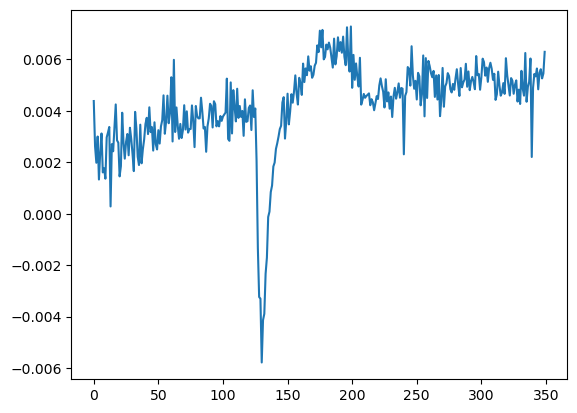

In [87]:
plt.plot(p1)